#**Image Colorization Through Autoencoders Part 2**

In [ ]:
!pip install catboost

     -------------------------------------- 101.0/101.0 MB 1.7 MB/s eta 0:00:00
     ---------------------------------------- 47.0/47.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
import os.path
from pathlib import Path
import glob
from PIL import Image
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from scipy.ndimage.filters import convolve
from skimage import data, io, filters
import skimage
from skimage.morphology import convex_hull_image, erosion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import RMSprop,Adam,Optimizer,Optimizer, SGD
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                        Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN, LSTM, GlobalAveragePooling2D, SeparableConv2D,\
ZeroPadding2D, Convolution2D, ZeroPadding2D, Conv2DTranspose,ReLU, UpSampling2D, Concatenate, Conv2DTranspose
from keras import models
from keras import layers
import tensorflow as tf
from keras.applications import VGG16,VGG19,inception_v3
from keras import backend as K
from keras.utils import plot_model
from keras.models import load_model
from keras import backend
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from warnings import filterwarnings
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

In [ ]:
Gray_NPY = np.load("l1/gray_scale.npy")
AB_1_NPY = np.load("ab1/ab/ab1.npy")

In [ ]:
print(type(Gray_NPY))
print(type(AB_1_NPY))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
print(Gray_NPY.shape)
print(AB_1_NPY.shape)

(25000, 224, 224)
(10000, 224, 224, 2)


In [ ]:
splitting_count = 300
end_splitting_count = 600

In [ ]:
X_Train = Gray_NPY[:splitting_count,:,:].astype("float32").reshape(splitting_count,Gray_NPY.shape[1],Gray_NPY.shape[2])

In [ ]:
X_Non_Seen = Gray_NPY[splitting_count:end_splitting_count,:,:].astype("float32").reshape(splitting_count,Gray_NPY.shape[1],Gray_NPY.shape[2])

In [ ]:
Y_Train = AB_1_NPY[:splitting_count,:,:].astype("float32")

In [ ]:
print(X_Train.shape)
print(X_Non_Seen.shape)
print(Y_Train.shape)

(300, 224, 224)
(300, 224, 224)
(300, 224, 224, 2)


In [ ]:
#CREATING LAB TO RGB AND TESTING SET
def line_image(gray_images,splitting_count=splitting_count,preprocess_function=preprocess_input):
    Zeros_Imp = np.zeros((splitting_count,224,224,3))
    for indexing in range(0,3):
        Zeros_Imp[:splitting_count,:,:,indexing] = gray_images[:splitting_count]
        
    return preprocess_function(Zeros_Imp)

In [ ]:
Input_Images = line_image(X_Train,splitting_count)

In [ ]:
Non_Seen_Input = line_image(X_Non_Seen,splitting_count)

In [ ]:
print(Input_Images.shape)

(300, 224, 224, 3)


In [ ]:
print(Non_Seen_Input.shape)

(300, 224, 224, 3)


In [ ]:
def from_lab_to_rgb(gray_images,ab_images,n=10):
    Zeros_Imp = np.zeros((n,224,224,3))
    
    Zeros_Imp[:,:,:,0] = gray_images[0:n:]
    Zeros_Imp[:,:,:,1:] = ab_images[0:n:]
    
    Zeros_Imp = Zeros_Imp.astype("uint8")
    
    Main_Img = []
    
    for indexing in range(0,n):
        Main_Img.append(cv2.cvtColor(Zeros_Imp[indexing],cv2.COLOR_LAB2RGB))
        
    Main_Img = np.array(Main_Img)
    
    return Main_Img

In [ ]:
Output_Images = preprocess_input(from_lab_to_rgb(X_Train,Y_Train,n=splitting_count))

In [ ]:
print(Output_Images.shape)

(300, 224, 224, 3)


In [ ]:
Gray_Zeros_Imp = np.zeros((splitting_count,Gray_NPY.shape[1],Gray_NPY.shape[2],1))
Gray_Zeros_Imp[:,:,:,0] = X_Train

In [ ]:
print(Gray_Zeros_Imp.shape)

(300, 224, 224, 1)


In [ ]:
print(Y_Train.shape)

(300, 224, 224, 2)


In [ ]:
print(Y_Train[:,:,:,1:].shape)

(300, 224, 224, 1)


In [ ]:
print(Y_Train[:,:,:,1:][2].shape)

(224, 224, 1)


In [ ]:
#TRANSFORMATION TO 3D FROM 2D
X_Train_Testing = np.zeros(shape=(splitting_count,224,224,3))

for indexing in range(len(Y_Train)):
    X_Train_Testing[:,:,:,0][indexing] = X_Train[:,:,:][indexing]
    X_Train_Testing[:,:,:,1:][indexing] = Y_Train[:,:,:,:][indexing]

X_Train_Testing = X_Train_Testing.astype("uint8")

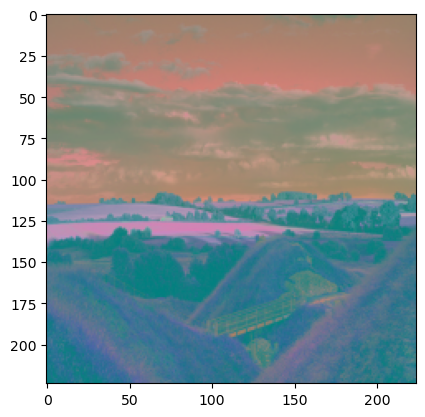

In [ ]:
# LAB
plt.imshow(X_Train_Testing[30]) 

In [ ]:
print(X_Train_Testing.shape)

(300, 224, 224, 3)


In [ ]:
Main_Img_Testing = []
    
for indexing in range(0,splitting_count):
    Main_Img_Testing.append(cv2.cvtColor(X_Train_Testing[indexing],cv2.COLOR_LAB2RGB))

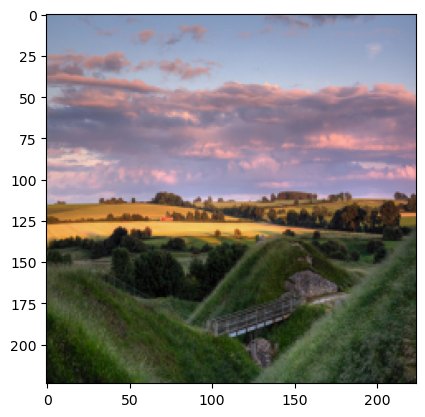

In [ ]:
# RGB
plt.imshow(Main_Img_Testing[30]) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


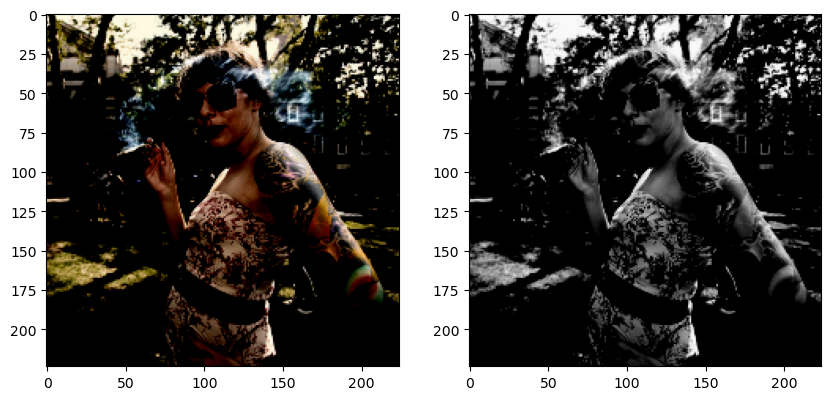

In [ ]:
figure,axis = plt.subplots(1,2,figsize=(10,10))

axis[0].imshow(Output_Images[0])
axis[1].imshow(Input_Images[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


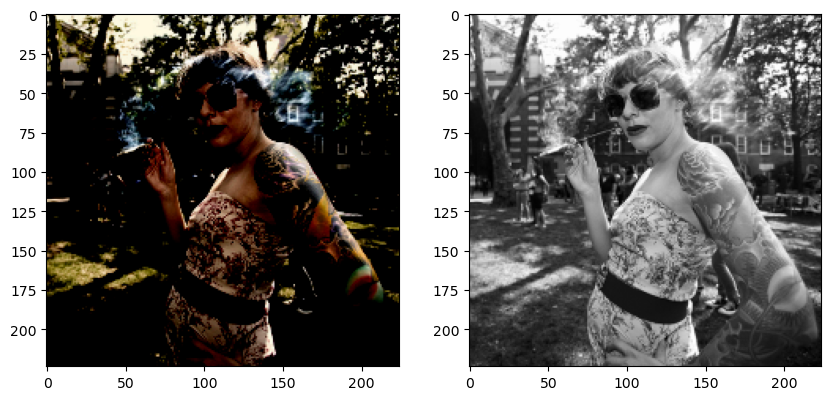

In [ ]:
figure,axis = plt.subplots(1,2,figsize=(10,10))

axis[0].imshow(Output_Images[0])
axis[1].imshow(X_Train[0],cmap="gray")

In [ ]:
# MODEL FOR COLORIZATION
compile_loss = "mse"
compile_optimizer = RMSprop(lr=0.0001,decay=1e-8)
compile_metrics = ["accuracy"]
input_dim = (Input_Images.shape[1],Input_Images.shape[2],Input_Images.shape[3])
output_class = 1

In [ ]:
Early_Stopper = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")
Checkpoint_Model = tf.keras.callbacks.ModelCheckpoint(monitor="val_accuracy",save_best_only=True,save_weights_only=True,filepath="./modelcheck")

In [ ]:
# Encoder Model
Encoder_G = Sequential()
Encoder_G.add(Conv2D(32,(2,2),kernel_initializer = 'he_normal',padding = "same",use_bias = True))
Encoder_G.add(BatchNormalization())
Encoder_G.add(ReLU())

Encoder_G.add(Conv2D(64,(2,2),kernel_initializer = 'he_normal',padding = "same",use_bias = True))
Encoder_G.add(BatchNormalization())
Encoder_G.add(ReLU())

Encoder_G.add(Conv2D(128,(2,2),kernel_initializer = 'he_normal',padding = "same",use_bias = True))
Encoder_G.add(BatchNormalization())
Encoder_G.add(ReLU())

Encoder_G.add(Conv2D(256,(2,2),kernel_initializer = 'he_normal',padding = "same",use_bias = True))
Encoder_G.add(BatchNormalization())
Encoder_G.add(ReLU())

# Decoder Model

Decoder_G = Sequential()
Decoder_G.add(Conv2DTranspose(128,(2,2),padding = "same",use_bias = True))
Decoder_G.add(ReLU())

Decoder_G.add(Conv2DTranspose(64,(2,2),padding = "same",use_bias = True))
Decoder_G.add(ReLU())

Decoder_G.add(Conv2DTranspose(32,(2,2),padding = "same",use_bias = True))
Decoder_G.add(ReLU())

Decoder_G.add(Conv2DTranspose(3,(2,2),padding = "same",use_bias = True))
Decoder_G.add(ReLU())

In [ ]:
Auto_Encoder = Sequential([Encoder_G,Decoder_G])

In [ ]:
Auto_Encoder.compile(loss=compile_loss,optimizer=compile_optimizer,metrics=compile_metrics)

In [ ]:
Auto_Encoder_Model = Auto_Encoder.fit(Input_Images,Output_Images,epochs=25,callbacks=[Early_Stopper,Checkpoint_Model],batch_size=16)

Epoch 1/25
19/19 [==============================] - 558s 28s/step - loss: 0.3695 - accuracy: 0.5485
Epoch 2/25
19/19 [==============================] - 496s 26s/step - loss: 0.3414 - accuracy: 0.5503
Epoch 3/25
19/19 [==============================] - 458s 24s/step - loss: 0.3374 - accuracy: 0.5558
Epoch 4/25
19/19 [==============================] - 599s 31s/step - loss: 0.3348 - accuracy: 0.5529
Epoch 5/25
19/19 [==============================] - 521s 27s/step - loss: 0.3350 - accuracy: 0.5531
Epoch 6/25
19/19 [==============================] - 508s 27s/step - loss: 0.3339 - accuracy: 0.5621
Epoch 7/25
19/19 [==============================] - 513s 27s/step - loss: 0.3318 - accuracy: 0.5629
Epoch 8/25
19/19 [==============================] - 513s 27s/step - loss: 0.3314 - accuracy: 0.5553
Epoch 9/25
19/19 [==============================] - 514s 27s/step - loss: 0.3312 - accuracy: 0.5669
Epoch 10/25
19/19 [==============================] - 507s 27s/step - loss: 0.3334 - accuracy: 0.5667

In [ ]:
Prediction_IMG = Auto_Encoder.predict(Input_Images[:30])

1/1 [==============================] - 21s 21s/step


In [ ]:
Prediction_Non_Seen = Auto_Encoder.predict(Non_Seen_Input[:30])

1/1 [==============================] - 16s 16s/step


In [ ]:
print(Prediction_IMG[20].shape)
print(Prediction_Non_Seen[20].shape)

(224, 224, 3)
(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'AUTO ENCODER OUTPUT')

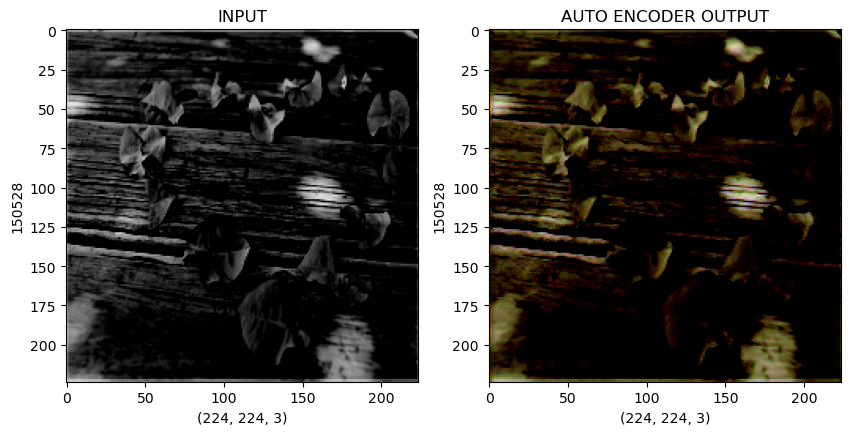

In [ ]:
figure,axis = plt.subplots(1,2,figsize=(10,10))
prediction_img_number = 1

Original_Img = Input_Images[prediction_img_number]
Predict_Image_AE = Prediction_IMG[prediction_img_number]

axis[0].imshow(Original_Img)
axis[0].set_xlabel(Original_Img.shape)
axis[0].set_ylabel(Original_Img.size)
axis[0].set_title("INPUT")
axis[1].imshow(Predict_Image_AE)
axis[1].set_xlabel(Predict_Image_AE.shape)
axis[1].set_ylabel(Predict_Image_AE.size)
axis[1].set_title("AUTO ENCODER OUTPUT")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'AUTO ENCODER OUTPUT')

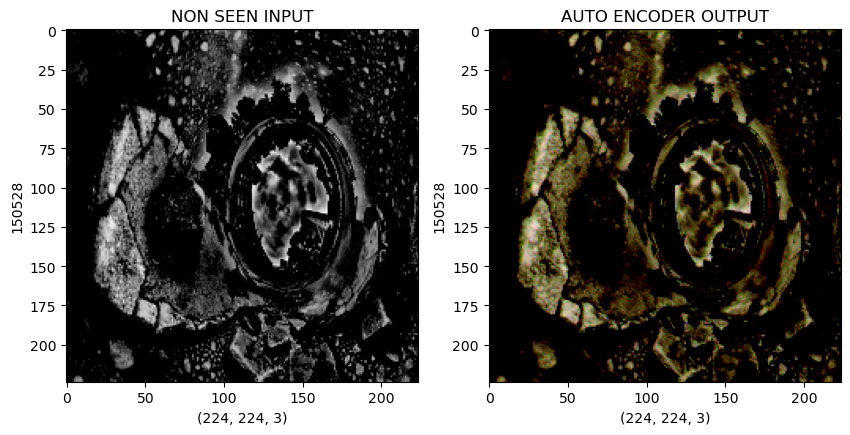

In [ ]:
figure,axis = plt.subplots(1,2,figsize=(10,10))
prediction_img_number = 2

Original_Img = Non_Seen_Input[prediction_img_number]
Predict_Image_AE = Prediction_Non_Seen[prediction_img_number]

axis[0].imshow(Original_Img)
axis[0].set_xlabel(Original_Img.shape)
axis[0].set_ylabel(Original_Img.size)
axis[0].set_title("NON SEEN INPUT")
axis[1].imshow(Predict_Image_AE)
axis[1].set_xlabel(Predict_Image_AE.shape)
axis[1].set_ylabel(Predict_Image_AE.size)
axis[1].set_title("AUTO ENCODER OUTPUT")